# 4. Activation functions and non-linearities

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### New mock dataset generation - Nonlinearity

...

In [2]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 100
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:5, :])
print(outputs[0:5])

(100,)
(100,)
(100, 2)
(100, 1)
[[-0.77  0.1 ]
 [ 0.95  0.6 ]
 [ 0.46 -0.37]
 [-0.3  -0.92]
 [ 0.42  0.62]]
[[1]
 [1]
 [0]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity.

In fact the function is no longer polynomial either due to the presence of a sine function.

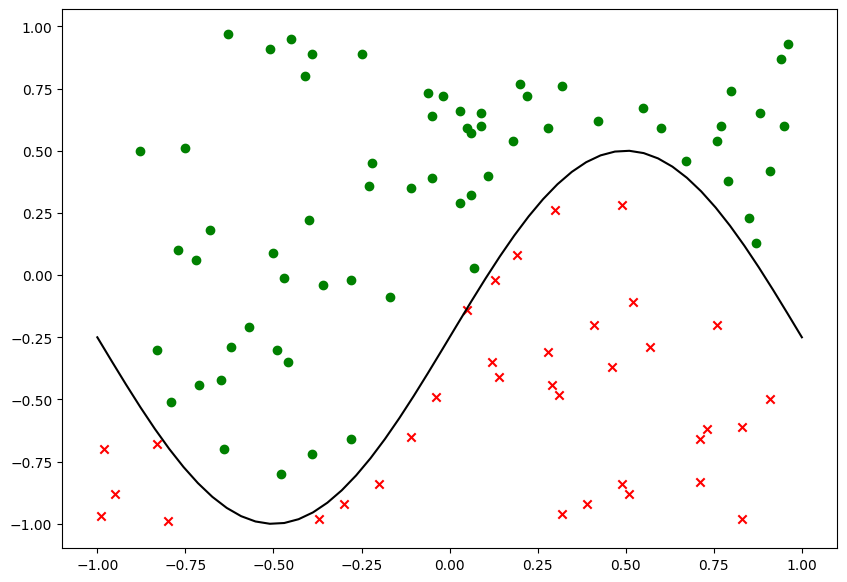

In [4]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### ShallowNeuralNet class without activation functions

If we were to reuse our previous **ShallowNeuralNet** class, we would make the assumption that the prices, surfaces and distances are connected via a linear function of some sort. Indeed, the two $ WX + b $ operations, in sequence, enventually produce a prediction, which is a linear function of the inputs.

To demonstrate, let us consider that $ n_x = 2 $, $ n_h = 4 $ and $ n_y = 1 $. In this configuration, we have:

$$ W_1 = \left( \begin{array}{cc} w^{(1)}_{1, 1}, & w^{(1)}_{1, 2}, & w^{(1)}_{1, 3}, & w^{(1)}_{1, 4} \\
w^{(1)}_{2, 1}, & w^{(1)}_{2, 2}, & w^{(1)}_{2, 3}, & w^{(1)}_{2, 4}\end{array} \right) $$

$$ b_1 = \left( \begin{array}{cc} b^{(1)}_{1, 1}, & b^{(1)}_{1, 2}, & b^{(1)}_{1, 3}, & b^{(1)}_{1, 4} \end{array} \right) $$

$$ W_2 = \left( \begin{array}{cc} w^{(2)}_{1, 1} \\ w^{(2)}_{1, 2} \\ w^{(2)}_{1, 3} \\ w^{(2)}_{1, 4} \end{array} \right) $$

$$ b_2 = \left( \begin{array}{cc} b^{(2)}_{1, 1} \end{array} \right) $$

After the first operation $ Z_1 = XW_1 + b_1 $, we have:

$$ Z_1 = \left( \begin{array}{cc} w^{(1)}_{1, 1} x_1 + w^{(1)}_{2, 1} x_2 + b^{(1)}_{1, 1}, & w^{(1)}_{1, 2} x_1 + w^{(1)}_{2, 2} x_2 + b^{(1)}_{1, 2}, & w^{(1)}_{1, 3} x_1 + w^{(1)}_{2, 3} x_2 + b^{(1)}_{1, 3}, & w^{(1)}_{1, 4} x_1 + w^{(1)}_{2, 4} x_2 + b^{(1)}_{1, 4} \end{array} \right) $$

After the second operation, the predicted price $ y_{pred} $ is given by $ y_{pred} = Z_1 W_2 + b_2 $

$$ y_{pred} = \left( \sum_{k=1}^4 w^{(1)}_{1, k} w^{(2)}_{1, k} \right) x_1 + \left( \sum_{k=1}^4 w^{(1)}_{2, k} w^{(2)}_{1, k} \right) x_2 + \left( \sum_{k=1}^4 b^{(1)}_{1, k} w^{(2)}_{1, k} \right) + b^{(2)}_{1, 1} $$

In [5]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
            
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        #  Adding clipping to keep prediction values
        # between 0 and 1 (see loss function!)
        pred = np.clip(Z2_b, 0, 1)
        return pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-5
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (1/m)*np.dot(Z1_b.T, epsilon)
        dL_db2 = (1/m)*np.sum(epsilon, axis = 0, keepdims = True)
        dL_dZ1 = np.dot(epsilon, self.W2.T)
        dL_dW1 = (1/m)*np.dot(inputs.T, dL_dZ1)
        dL_db1 = (1/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Compute all max variations
        max_gd_vars = np.max([np.max(np.abs(alpha*dL_dW1)), \
                              np.max(np.abs(alpha*dL_db1)), \
                              np.max(np.abs(alpha*dL_dW2)), \
                              np.max(np.abs(alpha*dL_db2))])
        
        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.CE_loss(inputs, outputs)
        
        return max_gd_vars
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            max_gd_vars = self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            if(max_gd_vars < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [6]:
# Define and train neural network structure (no activation)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net.train(inputs, outputs, N_max = 10000, alpha = 5e-3, delta = 1e-8, display = False)
print(shallow_neural_net.loss)

0.29783823594717523


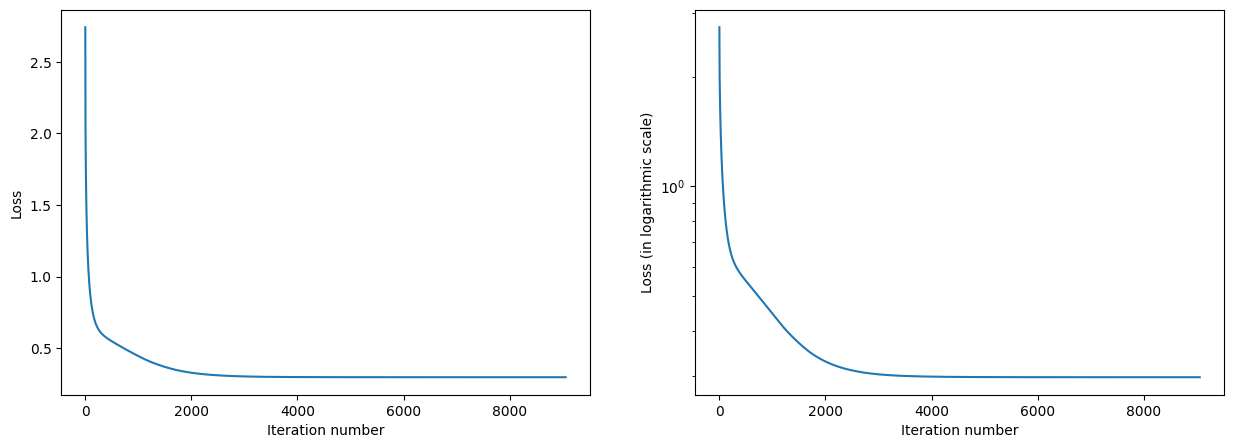

In [7]:
shallow_neural_net.show_losses_over_training()

Trains just fine! Or does it?

In [8]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

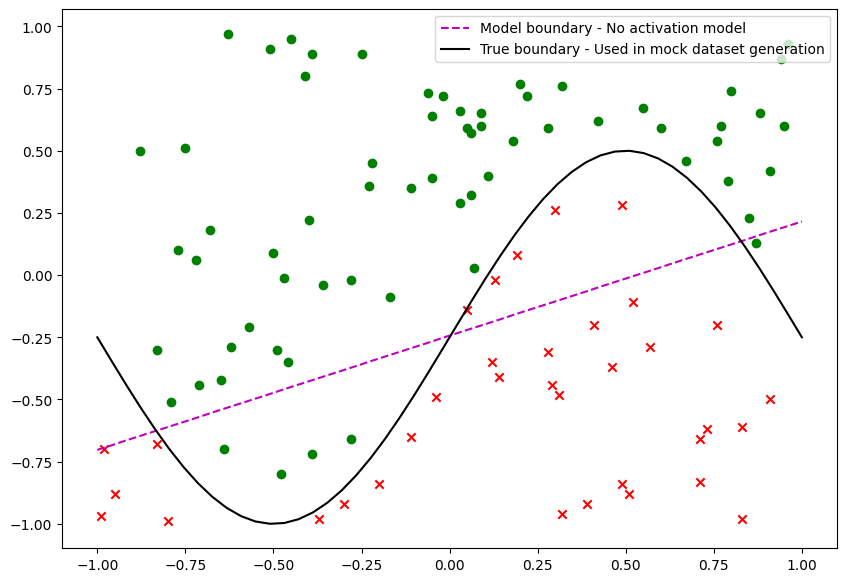

In [9]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display model boundary (no act model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_noact = [find_v2(v1, shallow_neural_net, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_noact, "m--", label = "Model boundary - No activation model")

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Show
plt.legend(loc = "best")
plt.show()

### Why use an activation function

Activation functions are an important component of neural networks because they introduce non-linearity to the model. This is important because most real-world data is non-linear, so a model that can model non-linear relationships is more likely to be accurate.

In [17]:
class ShallowNeuralNet_WithAct():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        gradient_output = dL_dA2*A2*(1 - A2)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Gradient descent update rules
        self.W2 -= (1/m)*alpha*np.dot(A1.T, gradient_output)
        self.W1 -= (1/m)*alpha*np.dot(inputs.T, gradient_hidden)
        self.b2 -= (1/m)*alpha*np.sum(gradient_output, axis = 0, keepdims = True)
        self.b1 -= (1/m)*alpha*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [18]:
# Define and train neural network structure (with activation)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_act = ShallowNeuralNet_WithAct(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_act.train(inputs, outputs, N_max = 100000, alpha = 5, delta = 1e-8, display = False)
print(shallow_neural_net_act.loss)

0.00022943092333062472


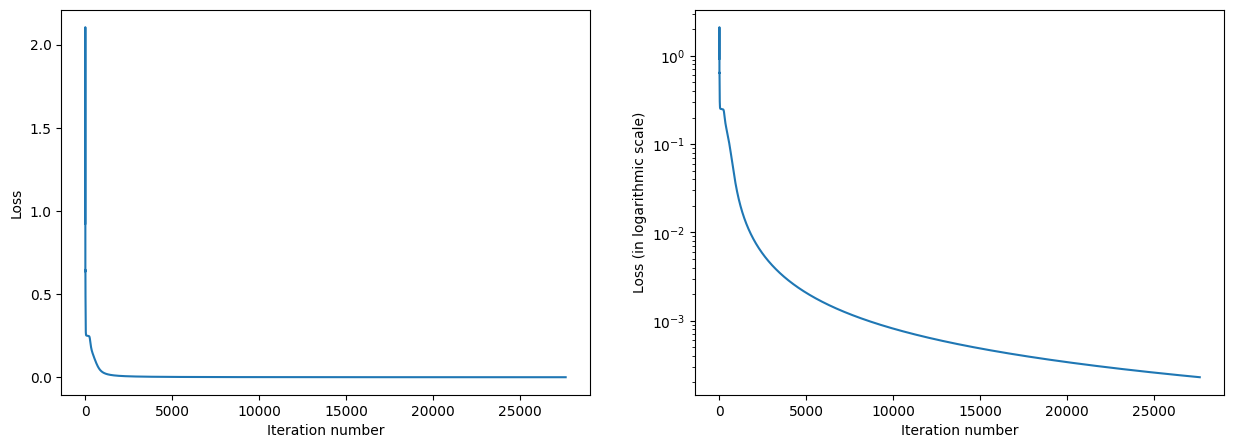

In [19]:
shallow_neural_net_act.show_losses_over_training()

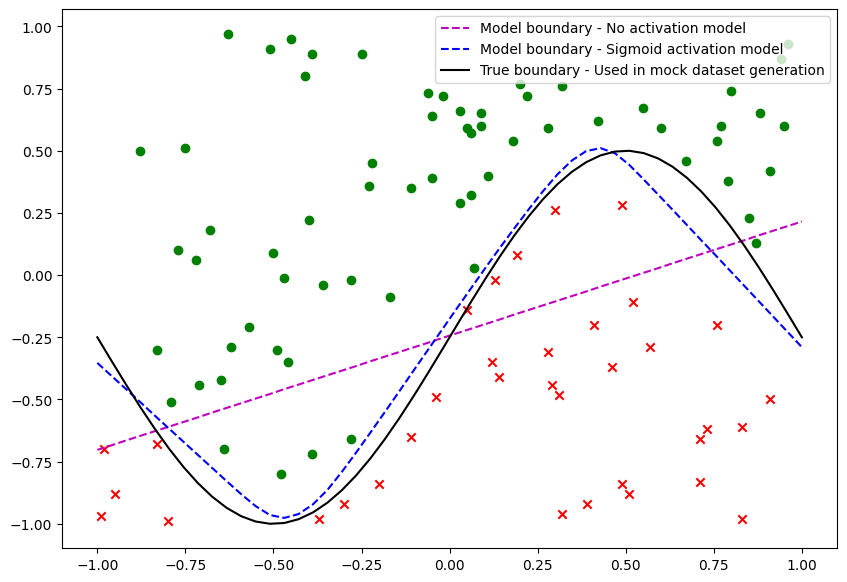

In [20]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display model boundary (no act model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_noact = [find_v2(v1, shallow_neural_net, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_noact, "m--", label = "Model boundary - No activation model")

# Display model boundary (sigmoid model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_act = [find_v2(v1, shallow_neural_net_act, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_act, "b--", label = "Model boundary - Sigmoid activation model")

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Show
plt.legend(loc = "best")
plt.show()

### More activation functions

Below are a few examples of activation functions and how to implement them, along with their curves. If you are not familiar with the np.where() function, now is the time to check the documentation! (https://numpy.org/doc/stable/reference/generated/numpy.where.html)

1. **Sigmoid**: The sigmoid activation function is a smooth, s-shaped curve that maps any input value to a value between 0 and It is often used in the output layer of a binary classification model, because the output can be interpreted as a probability.

2. **Tanh**: The tanh (short for "hyperbolic tangent") activation function is similar to the sigmoid function, but it maps values to a range between -1 and 1. Like the sigmoid function, it is often used in the output layer of a classification model.

3. **ReLU**: The ReLU (short for "rectified linear unit") activation function is a simple function that maps any input value less than 0 to 0, and any input value greater than or equal to 0 to the input value itself. It is widely used because it is computationally efficient and does not saturate (i.e., "die") like some other activation functions do.

4. **Leaky ReLU**: The leaky ReLU activation function is similar to the ReLU function, but it allows a small negative slope for input values less than 0. This can help to alleviate the "dying ReLU" problem, where some neurons in the network "die" and no longer respond to input.

5. **ELU**: The ELU (short for "exponential linear unit") activation function is similar to the ReLU function, but it has a negative slope for input values less than 0. Like the leaky ReLU function, it can help to alleviate the "dying ReLU" problem.

6. We have listed the most common activation functions, which are used 99% of the time. Keep in mind that **many more activation functions exist**, some of them being very niche, but worth keeping an eye on. Have a look at the list here: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

**Important note:** As with initializations, the choice of activation functions to use for your network typically depends on the characteristics of the problem you are trying to solve and the architecture of your network. But as before, there is no rule for the "best" activation functions to use for any given problem, rather a few empirical observations (recall the **"No free lunch theorem"**). For this reason, it is often helpful to try out a few different activation functions and see which one works best for your specific task. 

In [15]:
def sigmoid(val):
    return 1/(1 + np.exp(-val))
def tanh(val):
    return np.tanh(val)
def ReLU(val):
    return np.maximum(0, val)
def leaky_ReLU(val, alpha = 0.1):
    return np.where(val > 0, val, alpha*val)
def ELU(val, alpha = 0.1):
    return np.where(val > 0, val, alpha*(np.exp(val) - 1))

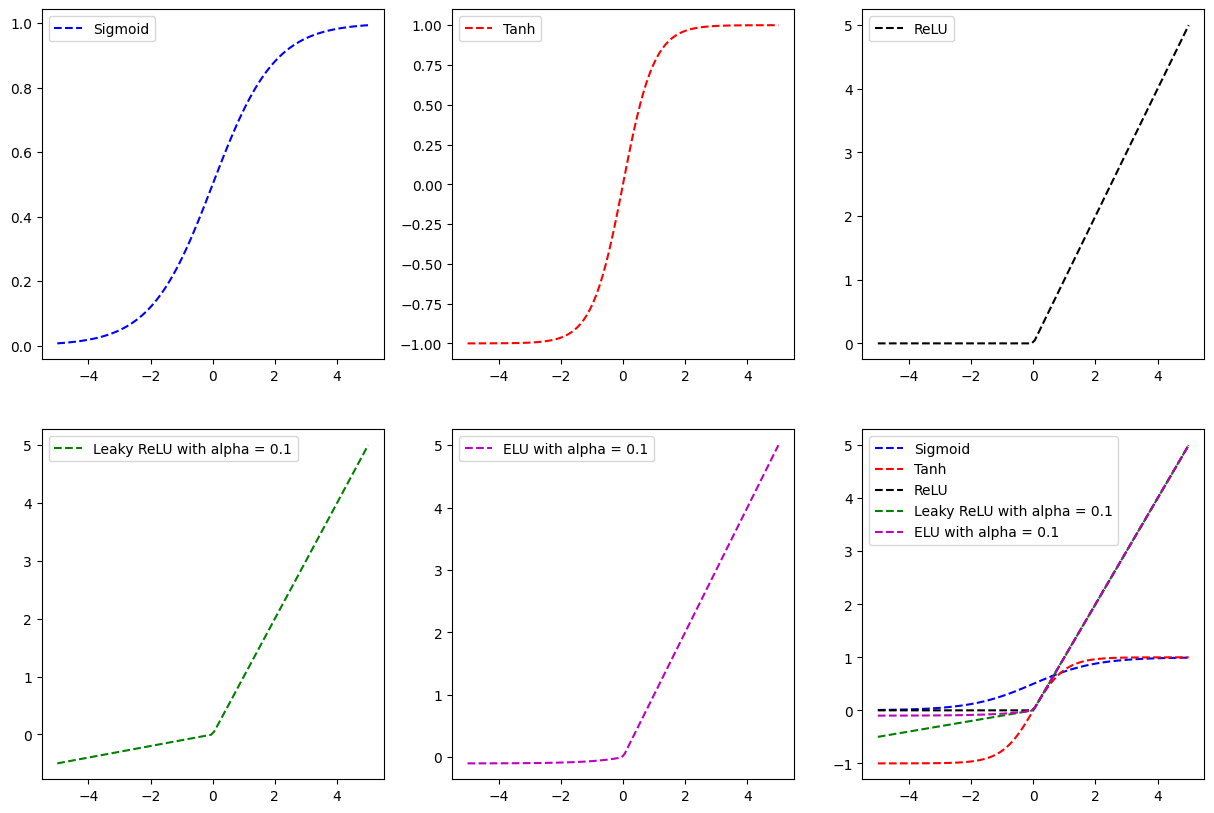

In [16]:
# Initialize plot
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
# X data
x = np.linspace(-5, 5, 100)

# All activation functions
y_sigmoid = [sigmoid(i) for i in x]
axs[0, 0].plot(x, y_sigmoid, "b--", label = "Sigmoid")
y_tanh = [tanh(i) for i in x]
axs[0, 1].plot(x, y_tanh, "r--", label = "Tanh")
y_relu = [ReLU(i) for i in x]
axs[0, 2].plot(x, y_relu, "k--", label = "ReLU")
y_lrelu = [leaky_ReLU(i) for i in x]
axs[1, 0].plot(x, y_lrelu, "g--", label = "Leaky ReLU with alpha = 0.1")
y_elu = [ELU(i) for i in x]
axs[1, 1].plot(x, y_elu, "m--", label = "ELU with alpha = 0.1")
axs[1, 2].plot(x, y_sigmoid, "b--", label = "Sigmoid")
axs[1, 2].plot(x, y_tanh, "r--", label = "Tanh")
axs[1, 2].plot(x, y_relu, "k--", label = "ReLU")
axs[1, 2].plot(x, y_lrelu, "g--", label = "Leaky ReLU with alpha = 0.1")
axs[1, 2].plot(x, y_elu, "m--", label = "ELU with alpha = 0.1")

# Show
axs[0, 0].legend(loc = "best")
axs[0, 1].legend(loc = "best")
axs[0, 2].legend(loc = "best")
axs[1, 0].legend(loc = "best")
axs[1, 1].legend(loc = "best")
axs[1, 2].legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate more advanced optimizers than the vanilla gradient descent one.